## **Downloading the data using Twitter API**

In [1]:
!pip install twarc -q     #Twarc
!pip install tweepy -q    #Tweepy 3.8.0
!pip install argparse -q    #Argparse 3.2
!pip install xtract -q    #Xtract 0.1 a3
!pip install wget -q    #Wget 3.2
!pip install -U -q PyDrive

     |████████████████████████████████| 54 kB 1.8 MB/s 
     |████████████████████████████████| 98 kB 6.5 MB/s 


In [2]:
!python -m pip install spacy==2.3.2 -q

     |████████████████████████████████| 9.9 MB 5.4 MB/s 
     |████████████████████████████████| 2.1 MB 48.2 MB/s 


In [3]:
# always restart session after spacy installation
!python -m spacy download pl_core_news_md  -q

     |████████████████████████████████| 79.9 MB 1.7 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('pl_core_news_md')


In [1]:
## install and download 
from IPython.display import clear_output
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import re
import numpy as np
import string
import time

# wizualizacja
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk - do preprocessingu
import nltk
from nltk.stem import WordNetLemmatizer
import spacy
# sklearn - modele do ML
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

### Download dataset containing tweets id's

Source: https://zenodo.org/record/5090588#.Ybe_7b3MJPb


In [2]:
#Authenticate
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
path = '/content/drive/MyDrive/pl_covid_tweets_clean.txt'   
df = pd.read_csv(path, delimiter = "\t")
print(df)

                   tweet_id        date      time lang country_place
0       1219370546116407297  2020-01-20  21:26:07   pl           NaN
1       1220355028961103872  2020-01-23  14:38:06   pl           NaN
2       1221099475982323712  2020-01-25  15:56:16   pl           NaN
3       1221232003393167360  2020-01-26  00:42:53   pl           NaN
4       1221344960194195457  2020-01-26  08:11:44   pl           NaN
...                     ...         ...       ...  ...           ...
583800  1414043803485409285  2021-07-11  02:08:09   pl           NaN
583801  1414043861954015232  2021-07-11  02:08:23   pl           NaN
583802  1414049377589645315  2021-07-11  02:30:18   pl           NaN
583803  1414064422453137411  2021-07-11  03:30:05   pl           NaN
583804  1414064490786734081  2021-07-11  03:30:21   pl           NaN

[583805 rows x 5 columns]


### Introducing Twitter credentials to authenticate


In [171]:
%run ./drive/MyDrive/my_keys.ipynb

In [ ]:
import tweepy
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

### Scrapping the Tweets from input dataframe and saving as txt file in Drive
This step need to be run only once

In [ ]:
#tweets = api.statuses_lookup(list(df['tweet_id'][:100]))
tweet_txt = []
sec = 0 
a = 0
b = 100
while sec < round(len(df)/100):
  try:
    tweets = api.statuses_lookup(list(df['tweet_id'][a:b]))
    for i in tweets:
      tweet_txt.append(i.text)
   
    if (sec % 100) == 0:
      with open('/content/drive/MyDrive/tweets.txt', 'w') as f:
        for item in tweet_txt:
        #line1 = item.split(",");
          item = item.replace('\n', ' ')
        #f.write(item + '\n')
          f.write("%s\n" % item)
      print("sequence number:", sec)
    sec+=1
    a = 100 * sec
    b = 100 + 100 * sec

  except BaseException as e:
          print('failed on_status,',str(e)) # print the error code obtained from twitter
          time.sleep(5) # provide a time before resuming the code when an error arises

### Loading the data

In [4]:
# Wczytywanie danych
PATH = '/content/drive/MyDrive/' 
tweets_txt = pd.read_csv(f'{PATH}tweets.txt', sep='delimiter', header = None)
tweets_txt.columns =['text']
tweets_txt['text'] = tweets_txt['text'].astype(str)

tweets_txt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


,text
0,"Kiedy #coronavirus dotrze do Polski, napotka o..."
1,Kolejni Polacy chcą wrócić z Wuhan https://t.c...
2,A tymczasem w Wuhan odcięto od reszty świata o...
3,@PatrykWachowiec @KancelariaSejmu nie zdziwię ...
4,".@MSZ_RP: 19 Polaków chce wrócić z Wuhan, w am..."
...,...
485082,Adi w natarciu 😁 https://t.co/CXdSR1AST2
485083,Kwarantanna osób zaszczepionych nie jest potrz...
485084,pkp 4.0 ready sik? https://t.co/fHzdNsd3AL
485085,"@rafalhubert Alfabet, jak będzie trzeba, to si..."


## **Data cleaning**

#### Drop duplicate values


In [5]:
# drop duplicate values
tweets_txt['text'].drop_duplicates(keep="first", inplace=True)
tweets_txt

,text
0,"Kiedy #coronavirus dotrze do Polski, napotka o..."
1,Kolejni Polacy chcą wrócić z Wuhan https://t.c...
2,A tymczasem w Wuhan odcięto od reszty świata o...
3,@PatrykWachowiec @KancelariaSejmu nie zdziwię ...
4,".@MSZ_RP: 19 Polaków chce wrócić z Wuhan, w am..."
...,...
485082,Adi w natarciu 😁 https://t.co/CXdSR1AST2
485083,Kwarantanna osób zaszczepionych nie jest potrz...
485084,pkp 4.0 ready sik? https://t.co/fHzdNsd3AL
485085,"@rafalhubert Alfabet, jak będzie trzeba, to si..."


#### Normalization - make all strings lowercase


In [6]:
### Normalization make all strings lowercase
tweets_txt['text']= tweets_txt['text'].str.lower() 
tweets_txt['text'].head()

0    kiedy #coronavirus dotrze do polski, napotka o...
1    kolejni polacy chcą wrócić z wuhan https://t.c...
2    a tymczasem w wuhan odcięto od reszty świata o...
3    @patrykwachowiec @kancelariasejmu nie zdziwię ...
4    .@msz_rp: 19 polaków chce wrócić z wuhan, w am...
Name: text, dtype: object

#### Stopwords

In [7]:
import spacy
nlp = spacy.load('pl_core_news_md')

In [8]:
lemma = WordNetLemmatizer()
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [9]:
stopwordlist = nlp.Defaults.stop_words
print(stopwordlist)

{'vi', 'viii', 'tu', 'możliwe', 'jakas', 'być', 'ku', 'byl', 'ktoś', 'dzisiaj', 'bardzo', 'to', 'dwa', 'twoim', 'taka', 'juz', 'aj', 'coś', 'naszych', 'kilku', 'wielu', 'dlatego', 'powinno', 'nasz', 'cie', 'jeden', 'ok', 'sobą', 'pana', 'ktos', 'roku', 'godz', 'pan', 'te', 'tego', 'jedynie', 'sama', 'było', 'choć', 'ze', 'sie', 'albo', 'żeby', 'mam', 'wszyscy', 'dla', 'bynajmniej', 'takie', 'twoja', 'że', 'wszystkich', 'moi', 'totez', 'lub', 'kazdy', 'żadnych', 'ciebie', 'nigdy', 'ponad', 'powinna', 'mna', 'ix', 'dwoje', 'ich', 'aż', 'niej', 'został', 'az', 'je', 'nim', 'ktorym', 'mogą', 'więc', 'moim', 'innych', 'ach', 'mamy', 'od', 'która', 'iz', 'zaś', 'jakichs', 'wszystko', 'przeciez', 'aczkolwiek', 'może', 'bardziej', 'nam', 'ktore', 'zadnych', 'on', 'moje', 'tys', 'twój', 'ależ', 'jego', 'no', 'cos', 'dosc', 'gdyż', 'inny', 'wiele', 'ja', 'był', 'razie', 'jemu', 'nasze', 'ktorego', 'rowniez', 'którzy', 'xi', 'soba', 'przy', 'bo', 'ono', 'nimi', 'dość', 'tam', 'jakos', 'ani', 'kim

#### Cleaning and tokenization

In [10]:
def clean_text(text):
  text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text) # URL 
  text = re.sub('\$[a-zA-Z0-9]*', ' ', text)
  text = re.sub('\@[a-zA-Z0-9]*', ' ', text)
  text = re.sub('[0-9]+', '', text)  # deleting numbers
  text = re.sub(r'(.)1+', r'1', text) # repeating chars
  #text = re.sub('[^a-zA-Z\']', ' ', text) 
 # text = re.sub(r'[^\w\s]','', text)
  #text = re.sub('[A-Za-zżźćńółęąśŻŹĆĄŚĘŁÓŃ]', ' ', text)
  #text.strip(string.punctuation)

  text = re.sub(r'[^\w\s]','',text) #remove everything except words and space
  text = re.sub(r'_','', text)
  text = re.sub('\t', '', text)
  text = ' '.join( [w for w in text.split() if len(w)>1] )
  text = ' '.join([lemma.lemmatize(x) for x in nltk.wordpunct_tokenize(text) if x not in stopwordlist])
  text = [lemma.lemmatize(x,nltk.corpus.reader.wordnet.VERB) for x in nltk.wordpunct_tokenize(text) if x not in stopwordlist]
  return text 

In [11]:
tweets_txt['clean_text'] = tweets_txt['text'].apply(clean_text)
tweets_txt.head()

,text,clean_text
0,"kiedy #coronavirus dotrze do polski, napotka o...","[coronavirus, dotrze, polski, napotka, opór, z..."
1,kolejni polacy chcą wrócić z wuhan https://t.c...,"[kolejni, polacy, chcą, wrócić, wuhan]"
2,a tymczasem w wuhan odcięto od reszty świata o...,"[tymczasem, wuhan, odcięto, reszty, świata, ob..."
3,@patrykwachowiec @kancelariasejmu nie zdziwię ...,"[zdziwię, powiedzą, listy, pojechały, chin, wu..."
4,".@msz_rp: 19 polaków chce wrócić z wuhan, w am...","[rp, polaków, wrócić, wuhan, ambasadzie, rp, p..."


In [12]:
tweets_txt.dropna(subset = ["clean_text"], inplace=True)
tweets_txt['cleaned_text'] = tweets_txt['clean_text'].apply(lambda x:' '.join(x))
tweets_txt

,text,clean_text,cleaned_text
0,"kiedy #coronavirus dotrze do polski, napotka o...","[coronavirus, dotrze, polski, napotka, opór, z...",coronavirus dotrze polski napotka opór znakomi...
1,kolejni polacy chcą wrócić z wuhan https://t.c...,"[kolejni, polacy, chcą, wrócić, wuhan]",kolejni polacy chcą wrócić wuhan
2,a tymczasem w wuhan odcięto od reszty świata o...,"[tymczasem, wuhan, odcięto, reszty, świata, ob...",tymczasem wuhan odcięto reszty świata obszar p...
3,@patrykwachowiec @kancelariasejmu nie zdziwię ...,"[zdziwię, powiedzą, listy, pojechały, chin, wu...",zdziwię powiedzą listy pojechały chin wuhan od...
4,".@msz_rp: 19 polaków chce wrócić z wuhan, w am...","[rp, polaków, wrócić, wuhan, ambasadzie, rp, p...",rp polaków wrócić wuhan ambasadzie rp pekinie ...
...,...,...,...
485082,adi w natarciu 😁 https://t.co/cxdsr1ast2,"[adi, natarciu]",adi natarciu
485083,kwarantanna osób zaszczepionych nie jest potrz...,"[kwarantanna, osób, zaszczepionych, potrzebna,...",kwarantanna osób zaszczepionych potrzebna przy...
485084,pkp 4.0 ready sik? https://t.co/fhzdnsd3al,"[pkp, ready, sik]",pkp ready sik
485085,"@rafalhubert alfabet, jak będzie trzeba, to si...","[alfabet, rozszerzy, look]",alfabet rozszerzy look


## **Labeling**

In [13]:
#gensim
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
#wordcloud 
from wordcloud import WordCloud 

In [14]:
sent = [row for row in tweets_txt['clean_text']]

phrases = Phrases(sent, min_count=1, progress_per=485087)
bigram = Phraser(phrases)
sentences = bigram[sent]
sentences[1]

['kolejni_polacy', 'chcą_wrócić', 'wuhan']

In [15]:
# inicjalizacja modelu word2vec
import multiprocessing
w2v_model = Word2Vec(min_count=4,
                     window=5,
                     size =300,
                     sample=1e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     seed= 42,
                     workers=multiprocessing.cpu_count()-1)


w2v_model.build_vocab(sentences, progress_per= 485087)

In [16]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(45031581, 89220000)

In [19]:
w2v_model.wv.most_similar(positive=["fajne"])

[('lubię', 0.9088984727859497),
 ('moda', 0.8970432281494141),
 ('memy', 0.8962926864624023),
 ('piękne', 0.8956923484802246),
 ('notatki', 0.8945770263671875),
 ('potrafisz', 0.8912384510040283),
 ('ehhh', 0.8911154270172119),
 ('zasięgi', 0.8889053463935852),
 ('filmach', 0.8841354250907898),
 ('znacie_jakieś', 0.8835195302963257)]

In [20]:
w2v_model.save("/content/drive/MyDrive/word2vec.model")

In [21]:
word_vectors = Word2Vec.load("/content/drive/MyDrive/word2vec.model").wv

In [22]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=2, max_iter=1000, random_state=42, n_init=50).fit(X=word_vectors.vectors.astype('double'))

In [23]:
word_vectors.similar_by_vector(model.cluster_centers_[1], topn=200, restrict_vocab=None)

[('zdrowotnych_formie', 0.9937599897384644),
 ('chiny_wzywają', 0.993700385093689),
 ('wielkie_ogniska', 0.993156373500824),
 ('wbrytania_przypadkiem', 0.9924830794334412),
 ('dolnośląskiego_świętokrzyskiego', 0.9921672940254211),
 ('stworzenia_globalnego', 0.9921330809593201),
 ('chińska_dziennikarka', 0.991966187953949),
 ('zapobiegać_pogorszeniu', 0.9918882250785828),
 ('zachodniopomorskim_urzędzie', 0.991742730140686),
 ('prof_bruno', 0.9916995763778687),
 ('wojewodzie_pokazuje', 0.9916785359382629),
 ('zmarł_osobisty', 0.9916049838066101),
 ('poprawy_humoru', 0.9913811683654785),
 ('lżejszym_przebiegu', 0.9912915825843811),
 ('alarmujące_informacje', 0.9912467002868652),
 ('pracownicy_jednego', 0.9909833073616028),
 ('prasy_szczepionka', 0.9909192323684692),
 ('paszportami_zaszczepionych', 0.990867555141449),
 ('mobilny_szpital', 0.9908087253570557),
 ('wojewódzkim_szczecinie', 0.9907767176628113),
 ('zachodniopomorskiego_świętokrzyskiego', 0.9906965494155884),
 ('okres_dawkami', 

In [24]:
positive_cluster_center = model.cluster_centers_[1]
negative_cluster_center = model.cluster_centers_[0]
#neutral_cluster_center= model.cluster_centers_[0]

In [25]:
words = pd.DataFrame(word_vectors.index2entity)
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])

In [26]:
words["cluster"].value_counts()

0    52609
1    45725
Name: cluster, dtype: int64

In [27]:
words['cluster_value'] = [1 if i==1 else 0 if i==0 else -1 for i in words.cluster]
words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)

In [28]:
words[words["cluster_value"]==1].sort_values("closeness_score")

,words,vectors,cluster,cluster_value,closeness_score
3412,von_der,"[0.2076732, 0.49503878, -0.25297233, 0.4320283...",1,1,0.087031
2766,premiera_d,"[0.58748555, 0.10457985, -0.43083534, -1.14815...",1,1,0.087060
803,jennie,"[1.0536873, 1.5470891, 0.27357933, -0.37356123...",1,1,0.088074
1914,główny_doradca,"[0.55409145, -0.07063867, -0.42771897, -1.1575...",1,1,0.088260
5569,możesz_następny,"[0.46834165, 0.1281706, -0.8076884, -0.5245768...",1,1,0.088790
...,...,...,...,...,...
95238,zdrowotnych_formie,"[0.18042773, 0.22012486, -0.14035828, -0.20387...",1,1,3.354899
61386,wojewódzkim_szczecinie,"[0.20435835, 0.23110408, -0.15958172, -0.21755...",1,1,3.364647
97388,prof_bruno,"[0.20107922, 0.20526673, -0.14447805, -0.23475...",1,1,3.367086
91767,wbrytania_przypadkiem,"[0.206388, 0.24189822, -0.1533662, -0.2164477,...",1,1,3.665452


In [29]:
words[words["cluster_value"]==0].sort_values("closeness_score")

,words,vectors,cluster,cluster_value,closeness_score
5306,prof_dr,"[-0.072749265, 0.41039243, -0.64929914, -1.601...",0,0,0.085962
2424,donalda_trumpa,"[1.2291235, -0.37932548, -0.7875736, -0.694080...",0,0,0.091502
4243,zapraszamy_lektury,"[-0.4100329, 0.84522134, -1.1814106, -0.278216...",0,0,0.095209
4601,prezydent_tanzanii,"[-0.41042227, 0.023242036, 0.2533992, -0.24409...",0,0,0.096162
4980,tweetów,"[0.20506766, 0.71671456, -1.5404503, -0.112246...",0,0,0.096277
...,...,...,...,...,...
59947,kurwaaa,"[0.14624013, 0.1558558, -0.13227122, -0.227995...",0,0,4.703756
77967,marvel,"[0.11658734, 0.13251914, -0.14841211, -0.22535...",0,0,5.243162
97030,berbeluchę,"[0.12719247, 0.15380555, -0.12806621, -0.18708...",0,0,5.491283
82091,pomnikami,"[0.12339112, 0.1414289, -0.1335412, -0.1999328...",0,0,5.881381


In [104]:
positive = ['miły','zajebisty','dobry','skuteczny','ładny','słodki','fajny', 'fenomenalny', 'fantastyczny']
#neutral = ['uniwersytet','akcja','aktor','gwiazda','kraj','las', 'cześć']
negative= ['koszmarny','głupi','zjebany','znudzony','zły','absurdalny', 'katastrofalny', 'chory', 'kurwa']
for i in positive:
    words.loc[words["words"]==i,"cluster_value"] = 1
    
#for i in neutral:
#    words.loc[words["words"]==i,"cluster_value"] = 0
    
for i in negative:
    words.loc[words["words"]==i,"cluster_value"] = 0


In [105]:
words[words["words"]=="głupi"]

,words,vectors,cluster,cluster_value,closeness_score,sentiments
2206,głupi,"[0.16027816, 0.00092366664, -0.034585755, -0.2...",0,0,0.276701,negative


In [106]:
words[words["words"]=="słodki"]

,words,vectors,cluster,cluster_value,closeness_score,sentiments
37685,słodki,"[0.14557512, 0.18081999, -0.14613414, -0.21229...",0,1,2.349522,positive


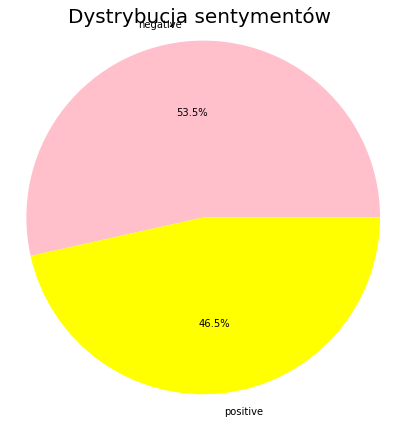

,index,sentiments
0,negative,52602
1,positive,45732


In [107]:
emotion = {#0: "neutral",
           1: "positive",
           0: "negative"}

words["sentiments"] = words["cluster_value"].map(emotion)

fig = plt.gcf()
fig.set_size_inches(7,7)
colors = ["pink","yellow"]
df_pie=words["sentiments"].value_counts().reset_index()
plt.pie(df_pie["sentiments"], labels = df_pie["index"], radius=2, colors=colors, autopct="%1.1f%%")
plt.axis('equal')
plt.title("Dystrybucja sentymentów ", fontsize=20)
plt.show()
df_pie

In [115]:
from math import nan
def get_sentiments(x, sent_dict):
    total = 0
    count = 0
    test = x["clean_text"]
    for t in test:
        if words_dict.get(t):
            total += int(sent_dict.get(t))
        count+=1 
    if count == 0:
     avg = 0 
    else:
      avg = total/count

    #print(avg)
    sentiment = 0 if avg < 0.5 else 1
    return sentiment

In [116]:
words_dict = dict(zip(words.words, words.cluster_value))

In [117]:
tweets_txt["sentiment"] = tweets_txt.apply(get_sentiments, args=(words_dict,), axis=1)

In [118]:
tweets_txt["sentiment"].value_counts()

0    285033
1    200054
Name: sentiment, dtype: int64

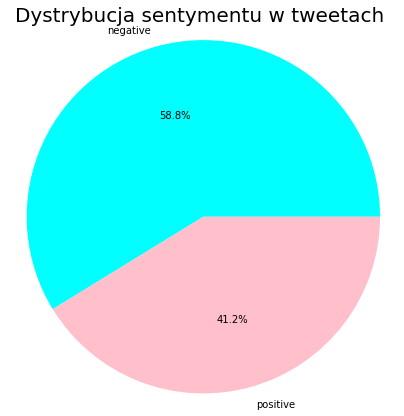

,index,sentiments_val
0,negative,285033
1,positive,200054


In [119]:
emotion = {1: "positive",
           0: "negative"}

tweets_txt["sentiments_val"] = tweets_txt["sentiment"].map(emotion)
df_pie = tweets_txt["sentiments_val"].value_counts().reset_index()
fig = plt.gcf()
fig.set_size_inches(7,7)
colors = ["cyan","pink"]
plt.pie(df_pie["sentiments_val"],labels= df_pie["index"],radius=2,autopct="%1.1f%%", colors=colors)
plt.axis('equal')
plt.title("Dystrybucja sentymentu w tweetach ", fontsize=20)
#plt.savefig("images/Sentiment_Distribution.png")
plt.show()
df_pie

In [120]:
#save the processed filed to drive
tweets_txt.to_csv("/content/drive/MyDrive/tweets_labeled_bi.csv")